In [104]:
import os
import numpy as np
import tensorflow as tf
import nibabel as nib
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

In [105]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [106]:
def remove_store(base_path, files):
    new_files = []
    for j in files:
        b_path = os.path.join(base_path, j)
        if(os.path.isdir(b_path)):
            new_files.append(b_path)
    return new_files

In [107]:
def get_data(tumor='LGG', pattern='t1'):
    # Get patient folders
    base_path = os.path.join('..', 'data', tumor)
    patients = os.listdir(base_path)
    p2 = remove_store(base_path, patients)
    #print(p2)
    #print(patients)
    urls = []
    for i in p2:
        # Get files for each patient
        # patient_path = os.path.join(base_path, i)
        files = [v for v in os.listdir(i) if v != '.DS_Store']
        #print(files)        
        for j in files:
            # m = re.match(r"^(?!.*(t2|flair|seg)).*", j)
            m = pattern in j
            if m:
                urls.append(os.path.join(i, j))
    # print(urls)
    if(pattern == 't1'):
        new_urls = [v for v in urls if 't1ce' not in v]
    else:
        new_urls = urls
    return new_urls

In [108]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

In [109]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64 # SLICES
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(
        img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [110]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [111]:
## LGG HGG

low_grade_paths = get_data(tumor='LGG', pattern='flair')
high_grade_paths = get_data(tumor='HGG', pattern='flair')

In [112]:
high_grade_paths

['..\\data\\HGG\\BraTS20_Training_001\\BraTS20_Training_001_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_002\\BraTS20_Training_002_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_003\\BraTS20_Training_003_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_004\\BraTS20_Training_004_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_005\\BraTS20_Training_005_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_006\\BraTS20_Training_006_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_007\\BraTS20_Training_007_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_008\\BraTS20_Training_008_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_009\\BraTS20_Training_009_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_010\\BraTS20_Training_010_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_011\\BraTS20_Training_011_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_012\\BraTS20_Training_012_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_Training_013\\BraTS20_Training_013_flair.nii.gz',
 '..\\data\\HGG\\BraTS20_

In [113]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
low_grade_scans = np.array([process_scan(path) for path in low_grade_paths])
high_grade_scans = np.array([process_scan(path) for path in high_grade_paths])

In [114]:
low_grade_scans[0].shape

(128, 128, 64)

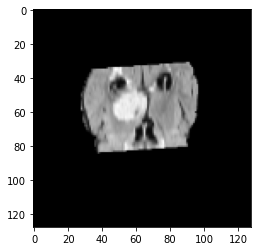

In [115]:
plt.imshow(low_grade_scans[0][:,:,30], cmap=mpl.cm.gray)

In [116]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
low_grade_labels = np.array([1 for _ in range(len(low_grade_scans))])
high_grade_labels = np.array([0 for _ in range(len(high_grade_scans))])

In [117]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((low_grade_scans[:50], high_grade_scans[:200]), axis=0)
y_train = np.concatenate((low_grade_labels[:50], high_grade_labels[:200]), axis=0)
x_val = np.concatenate((low_grade_scans[50:], high_grade_scans[200:]), axis=0)
y_val = np.concatenate((low_grade_labels[50:], high_grade_labels[200:]), axis=0)

In [118]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [119]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [120]:
batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [121]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 14, 64)    256   

In [122]:
# Train model
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "../neural_summary/3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=25)

# Train the model, doing validation at the end of each epoch
epochs = 25
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/25
125/125 - 40s - loss: 0.5884 - acc: 0.7440 - val_loss: 2.7944 - val_acc: 0.7797
Epoch 2/25
125/125 - 37s - loss: 0.5115 - acc: 0.7720 - val_loss: 2.2980 - val_acc: 0.7797
Epoch 3/25
125/125 - 37s - loss: 0.5202 - acc: 0.8080 - val_loss: 2.5993 - val_acc: 0.7712
Epoch 4/25
125/125 - 37s - loss: 0.5027 - acc: 0.8000 - val_loss: 2.0632 - val_acc: 0.7797
Epoch 5/25
125/125 - 37s - loss: 0.4544 - acc: 0.8160 - val_loss: 2.6576 - val_acc: 0.7797
Epoch 6/25
125/125 - 37s - loss: 0.4310 - acc: 0.8360 - val_loss: 2.2263 - val_acc: 0.7797
Epoch 7/25
125/125 - 37s - loss: 0.4680 - acc: 0.8120 - val_loss: 1.4596 - val_acc: 0.7627
Epoch 8/25
125/125 - 38s - loss: 0.4489 - acc: 0.8160 - val_loss: 2.4894 - val_acc: 0.7797
Epoch 9/25
125/125 - 37s - loss: 0.4271 - acc: 0.8360 - val_loss: 2.9125 - val_acc: 0.7797
Epoch 10/25
125/125 - 37s - loss: 0.4032 - acc: 0.8160 - val_loss: 3.5329 - val_acc: 0.7797
Epoch 11/25
125/125 - 38s - loss: 0.3763 - acc: 0.8280 - val_loss: 2.0434 - val_acc: 0.75

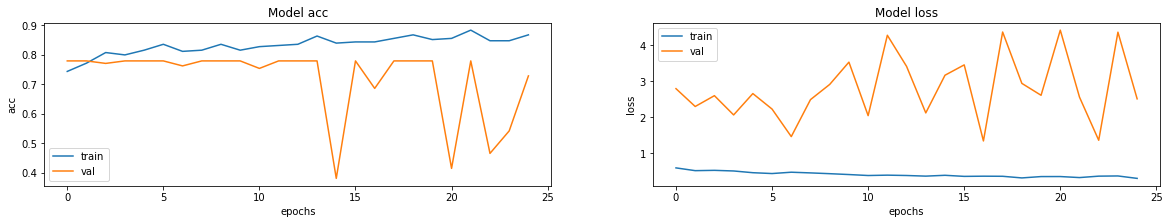

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
fig.savefig('../neural_summary/net_performance.jpg')

In [124]:
np.sum(model.history.history["loss"])/len(model.history.history["loss"]) # Loss en entrenamiento

0.4016212368011475

In [125]:
np.sum(model.history.history["acc"])/len(model.history.history["acc"]) # Precisión en entrenamiento

0.832960000038147

In [126]:
model.evaluate(x_val, y_val, batch_size=1) # Precisión en el conjunto de validación

118/118 [==============================] - 5s 42ms/step - loss: 2.5107 - acc: 0.7288


[2.51066255569458, 0.7288135886192322]

In [27]:
# La red se sobre entrenó, maybe porque son pocos datos en entrenamiento